

# <span style="color:red"> ***** </span><span style="color:blue"> Overview of Wav2Vec2, Character Duration, AST Transcript, and Language Model </span> <span style="color:green"> ***** </span>
Recent advancements in automatic speech recognition (ASR) and automatic speech translation (AST) have focused on leveraging large language models (LLMs) and innovative prompting techniques to enhance the performance of speech processing systems. This discussion synthesizes key concepts related to Wav2Vec2, character duration in speech transcripts, AST transcripts, and the integration of language models for effective speech extraction.

Wav2Vec2 and ASR

Wav2Vec2 is a self-supervised learning model developed by Facebook AI Research that processes raw audio waveforms for ASR tasks. It captures rich audio representations by training on large amounts of unlabeled data, making it highly effective for transcribing speech into text. The model operates by learning to predict masked portions of audio input, which allows it to understand phonetic and linguistic features without requiring extensive labeled datasets.

Character Duration in Speech Transcription

Character duration refers to the timing information associated with each spoken word or character in a transcript. This information is crucial for applications that require precise timing, such as subtitling or speech synthesis. Advanced ASR systems, like those utilizing Wav2Vec2, can provide timestamps for words in the output transcript, allowing developers to accurately align text with audio playback. For instance, systems can output timestamps that indicate when each word starts and ends during the speech, enhancing the usability of transcripts in multimedia applications5.

AST Transcripts and Chain-of-Thought Prompting

AST (Automatic Speech Translation) involves translating spoken language from one language to another in real-time. Recent research has proposed using ASR-generated transcripts as prompts for AST tasks within a framework known as Chain-of-Thought (CoT) prompting. This method enhances the translation process by first generating ASR transcripts from audio input and then using these transcripts to guide the translation process through an encoder-decoder model like Megatron-T512. The CoT approach has shown significant improvements in translation accuracy, achieving an average increase of 2.4 BLEU points across various tasks compared to traditional methods that do not utilize ASR transcripts1.

Integration of Language Models

Integrating language models into ASR systems can significantly improve transcription accuracy. Language models help predict the likelihood of word sequences based on context, which is particularly useful for disambiguating homophones or correcting errors in noisy environments. For example, using a simple N-gram language model alongside an ASR system can enhance the quality of transcriptions by selecting more probable word sequences based on linguistic patterns6.
Furthermore, Amazon Transcribe has introduced a new speech foundation model that supports over 100 languages and incorporates advanced features like automatic punctuation and speaker diarization. This model leverages self-supervised learning techniques to improve accuracy across diverse languages and accents3.

Conclusion

The integration of Wav2Vec2, character duration metrics, AST transcripts through CoT prompting, and robust language models represents a significant advancement in speech extraction technologies. These innovations not only enhance transcription accuracy but also facilitate more effective communication across languages through improved translation capabilities. As research continues to evolve in this area, we can expect further enhancements in how machines understand and process human speech.


Citations:
[1] https://arxiv.org/html/2409.11538v1
[2] https://arxiv.org/abs/2409.11538
[3] https://aws.amazon.com/ru/blogs/machine-learning/amazon-transcribe-announces-a-new-speech-foundation-model-powered-asr-system-that-expands-support-to-over-100-languages/
[4] https://aclanthology.org/2022.bigscience-1.2.pdf
[5] https://docs.nvidia.com/nemo-framework/user-guide/24.07/nemotoolkit/asr/intro.html
[6] https://www.assemblyai.com/blog/how-to-evaluate-speech-recognition-models/
[7] https://research.google/pubs/large-language-models-as-a-proxy-for-human-evaluation-in-assessing-the-comprehensibility-of-disordered-speech-transcription/
[8] https://aws.amazon.com/es/blogs/machine-learning/building-custom-language-models-to-supercharge-speech-to-text-performance-for-amazon-transcribe/


# <span style="color:red"> ***** </span><span style="color:blue"> Project Data File Folder</span> <span style="color:green"> ***** </span>

In [1]:
import sys, os
parent_dir = os.path.dirname(os.path.realpath('/Users/akpy27/Downloads/Untitled'))

# To get one directory up from the current file
project_dir = os.path.abspath(os.path.join(parent_dir, "./Untitled/"))

sys.path.insert(0,project_dir)

print ('Parent Directory Path:', parent_dir)
print ('Project Path:', project_dir)

Parent Directory Path: /Users/akpy27/Downloads
Project Path: /Users/akpy27/Downloads/Untitled


In [2]:
import torch
import numpy as np
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
import librosa
import xgboost as xgb
from collections import Counter
import openai
from glob import glob
from tqdm import tqdm
from transformers import GPTNeoForCausalLM, GPT2Tokenizer


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# <span style="color:red"> ***** </span><span style="color:blue"> Feature Extraction</span> <span style="color:green"> ***** </span>

In [ ]:
# Load Wav2Vec2 model and processor
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")
model_lm = GPTNeoForCausalLM.from_pretrained("EleutherAI/gpt-neo-1.3B")
tokenizer_lm = GPT2Tokenizer.from_pretrained("EleutherAI/gpt-neo-1.3B")
# Function to extract features using Wav2Vec2
def extract_wav2vec2_features(audio_file):
    # Load audio file
    audio, sr = librosa.load(audio_file, sr=16000)
    
    # Process audio with Wav2Vec2
    inputs = processor(audio, sampling_rate=16000, return_tensors="pt", padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Frame-level decisions (logits)
    frame_decisions = outputs.logits.squeeze().numpy()
    
    # ASR transcript
    predicted_ids = torch.argmax(outputs.logits, dim=-1)
    transcript = processor.batch_decode(predicted_ids)[0]
    
    return frame_decisions, transcript

def char_combination_frequency(transcript):
    char_pairs = [transcript[i:i+2] for i in range(len(transcript)-1)]
    return dict(Counter(char_pairs))
"""
# Function to get language model score using GPT-3
def get_lm_score(transcript):
    openai.api_key = 'add-here'
    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are a scoring system. Respond only with a number between 0 and 1 representing the naturalness of the given text. Do not provide any explanation."},
            {"role": "user", "content": f"Rate the naturalness of this text from 0 to 1:\n\n{transcript}"}
        ],
        max_tokens=5,  # Increased to allow for decimal responses
        n=1,
        temperature=0.3,  # Lowered for more consistent outputs
    )
    
    try:
        score = float(response.choices[0].message.content.strip())
        return max(0, min(score, 1))  # Ensure the score is between 0 and 1
    except ValueError:
        print(f"Error parsing score: {response.choices[0].message.content}")
        return 0.5  # Return a neutral score if parsing fails
    """

def get_lm_score(transcript):

    # Ensure pad token is set
    if tokenizer_lm.pad_token is None:
        tokenizer_lm.pad_token = tokenizer_lm.eos_token

    prompt = f"Rate the naturalness of this text from 0 to 1:\n\n{transcript}\n\nRating:"
    
    # Encode input and get attention mask
    inputs = tokenizer_lm(prompt, return_tensors="pt", padding=True)
    
    with torch.no_grad():
        outputs = model_lm.generate(
            inputs.input_ids,
            attention_mask=inputs.attention_mask,
            max_new_tokens=5,
            do_sample=True,
            temperature=0.3,
            pad_token_id=tokenizer_lm.pad_token_id
        )

    response = tokenizer_lm.decode(outputs[0])

    try:
        score = float(response.split("Rating:")[-1].strip())
        return max(0, min(score, 1))
    except ValueError:
        #print(f"Error parsing score: {response}")
        return 0.5
    
# Main function to extract all features
def extract_all_features(audio_file):
    frame_decisions, transcript = extract_wav2vec2_features(audio_file)
    char_freq = char_combination_frequency(transcript)
    lm_score = get_lm_score(transcript)
    #print(lm_score)
    
    # Combine features
    features = {
        'frame_decision_mean': np.mean(frame_decisions, axis=0),
        'char_duration_mean': np.mean([d for _, d in char_durations]),
        'char_freq_top5': sorted(char_freq.values(), reverse=True)[:5],
        'lm_score': lm_score,
        'transcript_length': len(transcript)
    }
    
    return features



Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
def get_label(file_name):
  '''
  Function to retrieve output labels from filenames
  '''
  if 'ROC' in file_name:
    label=0
  elif 'LES' in file_name:
    label=1
  elif 'DCB' in file_name:
    label=2
  elif 'PRV' in file_name:
    label=3
  elif 'VLD' in file_name:
    label=4
  elif 'DTA' in file_name:
    label=5
  else:
    raise ValueError('invalid file name')
  return label

# <span style="color:red"> ***** </span><span style="color:blue"> Train and Test Data Preparation</span> <span style="color:green"> ***** </span>

In [5]:
#First we obtain the list of all files in the train directory
train_files = glob(project_dir + "/project_data/train/*.wav")

#Let's sort it so that we're all using the same file list order
#and you can continue processing the features from a given file if it stops
#partway through running
train_files.sort()

train_feat=[]
train_label=[]
train_extracted_features=[]
for wav in tqdm(train_files):
    combined_features =extract_all_features(wav)
    train_extracted_features.append(combined_features)
    train_label.append(get_label(wav))



  6%|▌         | 528/8980 [04:22<1:10:04,  2.01it/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 8980/8980 [1:15:05<00:00,  1.99it/s]


In [6]:
#Now we obtain the list of all files in the test_clean directory
test_clean_files = glob(project_dir + '/project_data/test_clean/*.wav')

#Similar to above, we sort the files
test_clean_files.sort()

test_clean_feat=[]
test_clean_label=[]
test_clean_extracted_features=[]

for wav in tqdm(test_clean_files):
  combined_features =extract_all_features(wav)
  test_clean_extracted_features.append(combined_features)
  test_clean_label.append(get_label(wav))



100%|██████████| 2533/2533 [21:38<00:00,  1.95it/s]


In [7]:
#Finally we obtain the list of all files in the test_noisy directory
test_noisy_files = glob(project_dir + '/project_data/test_noisy/*.wav')

#Similar to above, we sort the files
test_noisy_files.sort()

test_noisy_feat=[]
test_noisy_label=[]
test_noisy_extracted_features=[]
for wav in tqdm(test_noisy_files):
    combined_features =extract_all_features(wav)
    test_noisy_extracted_features.append(combined_features)
    test_noisy_label.append(get_label(wav))



100%|██████████| 3238/3238 [27:29<00:00,  1.96it/s]


# <span style="color:red"> ***** </span><span style="color:blue"> Model Training and Predictions</span> <span style="color:green"> ***** </span>

In [1]:
import xgboost
import numpy as np
import shap
import pandas as pd

#Format input data

#Edit this variable to create a list that contains your feature names

train_feat_df = pd.DataFrame(data=(train_extracted_features))
train_feat_df['frame_decision_mean'] = train_feat_df['frame_decision_mean'].apply(lambda x: np.array(x).astype(float))
train_feat_df['char_freq_top5'] = train_feat_df['char_freq_top5'].apply(lambda x: [float(i) for i in x])

for i in range(5):
    train_feat_df[f'char_freq_top_{i+1}'] = train_feat_df['char_freq_top5'].apply(lambda x: x[i] if len(x) > i else None)
train_feat_df = train_feat_df.drop('char_freq_top5', axis=1)

for i in range(32):
    train_feat_df[f'frame_decision_mean_{i+1}'] = train_feat_df['frame_decision_mean'].apply(lambda x: x[i] if len(x) > i else None)
train_feat_df = train_feat_df.drop('frame_decision_mean', axis=1)

y_train=(train_label)


test_clean_feat_df = pd.DataFrame(data=(test_clean_extracted_features))

test_clean_feat_df['frame_decision_mean'] = test_clean_feat_df['frame_decision_mean'].apply(lambda x: np.array(x).astype(float))
test_clean_feat_df['char_freq_top5'] = test_clean_feat_df['char_freq_top5'].apply(lambda x: [float(i) for i in x])

for i in range(5):
    test_clean_feat_df[f'char_freq_top_{i+1}'] = test_clean_feat_df['char_freq_top5'].apply(lambda x: x[i] if len(x) > i else None)
test_clean_feat_df = test_clean_feat_df.drop('char_freq_top5', axis=1)

for i in range(32):
    test_clean_feat_df[f'frame_decision_mean_{i+1}'] = test_clean_feat_df['frame_decision_mean'].apply(lambda x: x[i] if len(x) > i else None)
test_clean_feat_df = test_clean_feat_df.drop('frame_decision_mean', axis=1)

y_test_clean=(test_clean_label)


test_noisy_feat_df = pd.DataFrame(data=(test_noisy_extracted_features))

test_noisy_feat_df['frame_decision_mean'] = test_noisy_feat_df['frame_decision_mean'].apply(lambda x: np.array(x).astype(float))
test_noisy_feat_df['char_freq_top5'] = test_noisy_feat_df['char_freq_top5'].apply(lambda x: [float(i) for i in x])
for i in range(5):
    test_noisy_feat_df[f'char_freq_top_{i+1}'] = test_noisy_feat_df['char_freq_top5'].apply(lambda x: x[i] if len(x) > i else None)
test_noisy_feat_df = test_noisy_feat_df.drop('char_freq_top5', axis=1)

for i in range(32):
    test_noisy_feat_df[f'frame_decision_mean_{i+1}'] = test_noisy_feat_df['frame_decision_mean'].apply(lambda x: x[i] if len(x) > i else None)
test_noisy_feat_df = test_noisy_feat_df.drop('frame_decision_mean', axis=1)

y_test_noisy=(test_noisy_label)

XGBoostError: 
XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed
    - vcomp140.dll or libgomp-1.dll for Windows
    - libomp.dylib for Mac OSX
    - libgomp.so for Linux and other UNIX-like OSes
    Mac OSX users: Run `brew install libomp` to install OpenMP runtime.

  * You are running 32-bit Python on a 64-bit OS

Error message(s): ["dlopen(/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/lib/libxgboost.dylib, 0x0006): Library not loaded: @rpath/libomp.dylib\n  Referenced from: <F2F42313-BF4F-3B95-A853-AE1DE94D4C87> /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/lib/libxgboost.dylib\n  Reason: tried: '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file)"]


In [ ]:
"""import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 7,9],
    'learning_rate': [0.1, 0.01, 0.001,0.0001],
    'subsample': [0.5, 0.7, 0.9, 1],
    'n_estimators':[100,300,600,1000]
}

# Create the XGBoost model object
xgb_model = xgb.XGBClassifier(objective='multi:softmax',eval_metric='mlogloss')

# Create the GridSearchCV object
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to the training data
grid_search.fit(train_feat_df,y_train)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)"""

'import xgboost as xgb\nfrom sklearn.model_selection import GridSearchCV\n\n# Define the hyperparameter grid\nparam_grid = {\n    \'max_depth\': [3, 5, 7,9],\n    \'learning_rate\': [0.1, 0.01, 0.001,0.0001],\n    \'subsample\': [0.5, 0.7, 0.9, 1],\n    \'n_estimators\':[100,300,600,1000]\n}\n\n# Create the XGBoost model object\nxgb_model = xgb.XGBClassifier(objective=\'multi:softmax\',eval_metric=\'mlogloss\')\n\n# Create the GridSearchCV object\ngrid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring=\'accuracy\')\n\n# Fit the GridSearchCV object to the training data\ngrid_search.fit(train_feat_df,y_train)\n\n# Print the best set of hyperparameters and the corresponding score\nprint("Best set of hyperparameters: ", grid_search.best_params_)\nprint("Best score: ", grid_search.best_score_)'

In [ ]:
model = xgb.XGBClassifier()  # multiclass logloss

model.fit(train_feat_df,y_train)

print("Train Clean Acc =", np.sum(y_train==model.predict(train_feat_df))/len(y_train))

print("Test Clean Acc =", np.sum(y_test_clean==model.predict(test_clean_feat_df))/len(y_test_clean))

print("Test Noisy Acc =", np.sum(y_test_noisy==model.predict(test_noisy_feat_df))/len(y_test_noisy))

Train Clean Acc = 0.9966592427616926
Test Clean Acc = 0.2506908803789972
Test Noisy Acc = 0.2554045707226683


In [ ]:
model.save_model('wec2vec2_combined.json')

# <span style="color:red"> ***** </span><span style="color:blue"> Interpreting Results and Explainability</span> <span style="color:green"> ***** </span>

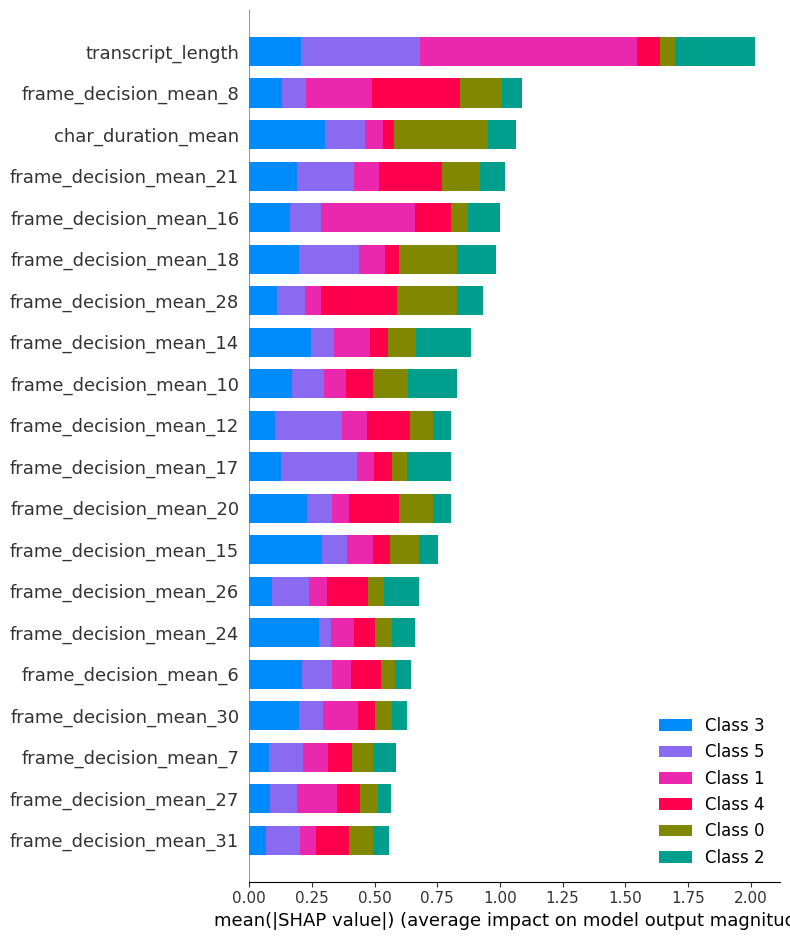

In [13]:
import shap

# Explain the model's predictions using SHAP by computing SHAP values
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(train_feat_df)

#Convert the shap values for each class to a single list
shap_as_list=[]
for i in range(6):
    shap_as_list.append(shap_values[:,:,i])

# Plot the SHAP values
shap.summary_plot(shap_as_list, train_feat_df, plot_type="bar")

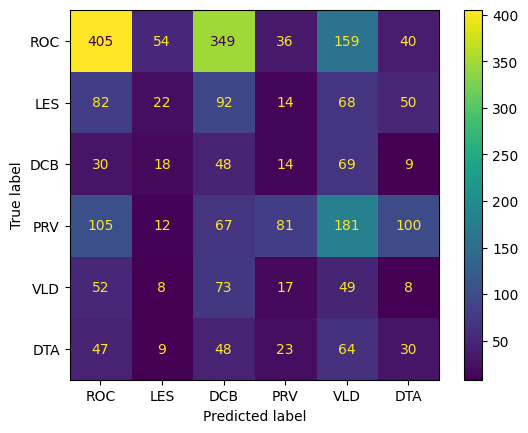

In [14]:
from sklearn import metrics
import matplotlib.pyplot as plt

confusion_matrix_clean = metrics.confusion_matrix(y_test_clean, model.predict(test_clean_feat_df))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_clean, display_labels = ['ROC','LES','DCB','PRV','VLD', 'DTA'])
cm_display.plot()
plt.show()

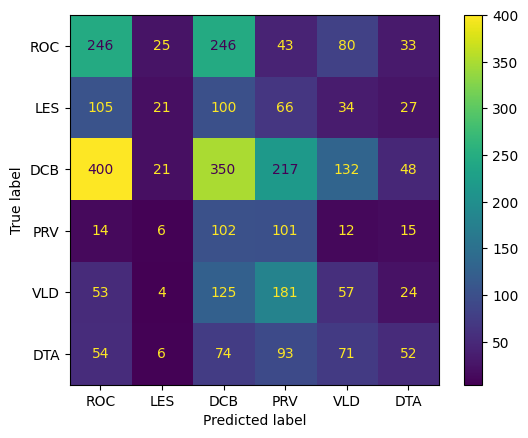

In [15]:
confusion_matrix_noisy = metrics.confusion_matrix(y_test_noisy, model.predict(test_noisy_feat_df))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_noisy, display_labels = ['ROC','LES','DCB','PRV','VLD', 'DTA'])
cm_display.plot()
plt.show()